In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# We know rho3 is the good rho. Use it to calculate p-value

In [2]:
from scipy.special import expit
rho1 = expit(-9.19) # the inverse of logit.
rho2=  expit(-1.15)
rho3 = expit(-3.24)

In [3]:
def get_alpha_beta(mu, rho):
    ''' rho and mu can be reparameterized into alpha and beta
    just because this is what python takes '''
    #https://dcgerard.github.io/updog/reference/betabinom.html
    
    alpha = mu*(1-rho)/rho
    beta=(1-mu)*(1-rho)/rho
    
    return alpha, beta
    

# Now we use the parameters to test IP vs IN

In [4]:
counts = pd.read_csv('/home/hsher/scratch/rar11_input.tsv', sep = '\t')
counts.shape

(125726, 25)

In [5]:
rep1='PP_Monosome2' ### IP
rep2='PP_Input2' ### IN
r1_handle = f'BSJ-{rep1}'
r2_handle = f'BSJ-{rep2}'


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from scipy.stats import betabinom
from scipy.stats import poisson

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)


counts['total_bsj']=counts[r1_handle]+counts[r2_handle]
total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
mu = total_bsj[r1_handle]/total_bsj.sum()

print(f'MLE of mu={mu}')

MLE of mu=0.1408463252433547


In [8]:



alpha_bsj, beta_bsj = get_alpha_beta(mu, rho3)


counts['total_bsj']=counts[r1_handle]+counts[r2_handle]
counts[f'pvalue']=counts.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                                            a=alpha_bsj, b = beta_bsj).cdf(row[r1_handle]), axis =1)



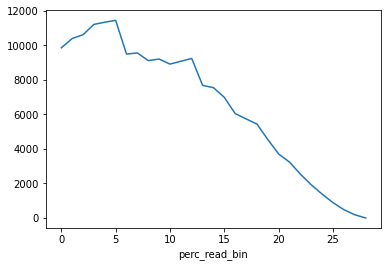

In [9]:
# multiple hypothesis testing, test the high coverage circle only
FDR_threshold = 0.2
from statsmodels.stats.multitest import fdrcorrection

counts['perc_read']=(counts[r1_handle]/counts[r1_handle].sum())+(counts[r2_handle]/counts[r2_handle].sum())

counts['perc_read_bins']=pd.qcut(counts['perc_read'], q = 100, duplicates = 'drop', labels = False)

# gradually decrease read cutoff to test, select cutoff the maximize the number of hits
n_rejected = []
for nread_bin in counts['perc_read_bins'].value_counts().sort_index(ascending = False).index:
    rejected, fdr = fdrcorrection(counts.loc[counts['perc_read_bins']>nread_bin, f'pvalue'],
                                  alpha = FDR_threshold)
    n_rejected.append([nread_bin, rejected.sum()])
n_rejected = pd.DataFrame(n_rejected, columns = ['perc_read_bin', 'n_rejected'])
n_rejected.set_index('perc_read_bin')['n_rejected'].plot()
threshold = n_rejected.set_index('perc_read_bin')['n_rejected'].idxmax()



In [10]:
results = counts.loc[counts['perc_read_bins']>threshold]
results['rejected'], results[f'FDR'] = fdrcorrection(results[f'pvalue'],
                          alpha = FDR_threshold)

counts[f'FDR']=results[f'FDR']
counts[f'tested']=counts.index.isin(results.index)

/scratch/hsher/33436865.tscc-mgr7.local/ipykernel_26804/3646191007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['rejected'], results[f'FDR'] = fdrcorrection(results[f'pvalue'],
/scratch/hsher/33436865.tscc-mgr7.local/ipykernel_26804/3646191007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['rejected'], results[f'FDR'] = fdrcorrection(results[f'pvalue'],


In [11]:
# these are the hits!
counts.loc[counts[f'FDR']<FDR_threshold]

,Unnamed: 0,seqname,source,feature,start,end,strand,frame,circ_id,circ_type,...,FSJ-PP_Polysome1,FSJ-PP_Polysome2,FSJ-PP_Input2,FSJ-PP_Monosome1,total_bsj,pvalue,perc_read,perc_read_bins,FDR,tested
3,3,chr1,CIRIquant,circRNA,955923.0,957273.0,-,.,chr1:955923|957273,exon,...,0.0,0.0,220.0,0.0,7.0,0.000430,0.000032,21,0.001931,True
5,5,chr1,CIRIquant,circRNA,1223244.0,1223968.0,-,.,chr1:1223244|1223968,exon,...,317.0,923.0,779.0,816.0,454.0,0.007641,0.001256,28,0.027118,True
14,14,chr1,CIRIquant,circRNA,1387235.0,1390865.0,-,.,chr1:1387235|1390865,exon,...,0.0,0.0,39.0,0.0,9.0,0.002912,0.000034,21,0.011590,True
45,45,chr1,CIRIquant,circRNA,1806475.0,1839238.0,-,.,chr1:1806475|1839238,exon,...,0.0,0.0,1184.0,0.0,15.0,0.000423,0.000061,24,0.001920,True
51,51,chr1,CIRIquant,circRNA,1815756.0,1853297.0,-,.,chr1:1815756|1853297,intron,...,0.0,0.0,1603.0,0.0,5.0,0.004553,0.000020,17,0.017322,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80460,19673,chrX,CIRIquant,circRNA,152959699.0,152969484.0,+,.,chrX:152959699|152969484,exon,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000018,16,0.000000,True
80461,19674,chrX,CIRIquant,circRNA,154436016.0,154436403.0,+,.,chrX:154436016|154436403,exon,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000012,13,0.000000,True
80462,19678,chrX,CIRIquant,circRNA,154969331.0,154999600.0,-,.,chrX:154969331|154999600,exon,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.000006,6,0.000000,True
80463,19679,chrX,CIRIquant,circRNA,155073377.0,155096287.0,+,.,chrX:155073377|155096287,intron,...,0.0,16.0,0.0,0.0,1.0,0.000000,0.000006,6,0.000000,True
